# XJCO2121 Data Mining - Coursework 2

Author: Tang Shiyu

Student ID: 2022116003

In [14]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

In [15]:
# Add Chinese stopwords set
stopwords = set()
stopword_files = ['baidu_stopwords', 'cn_stopwords', 'hit_stopwords', 'scu_stopwords']
for file in stopword_files:
    with open(f'stopwords-master/{file}.txt', 'r', encoding='utf-8') as f:
        for line in f:
            word = line.strip()
            if word:
                stopwords.add(word)

def preprocess_text_zh(text):
    # Use jieba to cut the words
    words = jieba.lcut(text)
    filtered_words = [word for word in words if word not in stopwords and len(word.strip()) > 0]
    return ' '.join(filtered_words)

# Define the text divider
def tokenizer(text):
    return jieba.lcut(text)

In [16]:
# Defines all fields used
fields = [
    {'name': 'advertisement', 'files': ['Advertising Planning', 'Additional', 'Brand Marketing']},
    {'name': 'print', 'files': ['drawing']},
    {'name': 'technology', 'files': ['technological development', 'Technology Outlook']}
]

# Defines all models
models = {
    'NB': MultinomialNB(),
    'SVM': LinearSVC(random_state=1)
}

# Store every field's data and results
fields_data = {}
fields_results = {}

Processing advertisement's data:
The number of data in Advertising Planning is 7514
The number of data in Additional is 7744
The number of data in Brand Marketing is 3739
After deleting repeated data, the number of data in advertisement is 10539


,comment_id,create_time,content,nickname,sub_comment_count,like_count,sentiment
0,667408e60000000017012a2a,1718880488000,还好我boss不懂看我出单还表扬我了,木子,131.0,31.0,negative
1,66596c33000000000f0077bc,1717136435000,做的好棒！,豆花要加糖,4.0,2.0,positive
2,665961c1000000000e033c6c,1717133762000,真诚发问这个豆奶口感咋样好喝吗早八人很需要啊宝子,小红薯62E23D58,3.0,2.0,positive
3,667978b100000000150082e2,1719236785000,求分享,捞起月亮的渔民,1.0,0.0,positive
4,665975d0000000001b007630,1717138897000,哇塞你们画的也太多了吧,小红薯63E82F05,3.0,1.0,negative


<class 'pandas.core.frame.DataFrame'>
Index: 10539 entries, 0 to 3704
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   comment_id         10539 non-null  object 
 1   create_time        10539 non-null  int64  
 2   content            10539 non-null  object 
 3   nickname           10539 non-null  object 
 4   sub_comment_count  10539 non-null  float64
 5   like_count         10539 non-null  float64
 6   sentiment          10539 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 658.7+ KB


None

,create_time,sub_comment_count,like_count
count,1.053900e+04,10539.000000,10539.000000
mean,1.716603e+12,0.492741,4.038808
std,1.244362e+10,5.515641,123.713814
min,1.640227e+12,0.000000,0.000000
25%,1.711402e+12,0.000000,0.000000
50%,1.719459e+12,0.000000,0.000000
75%,1.726363e+12,1.000000,1.000000
max,1.728960e+12,427.000000,8803.000000


sentiment
negative    5449
positive    5090
Name: count, dtype: int64


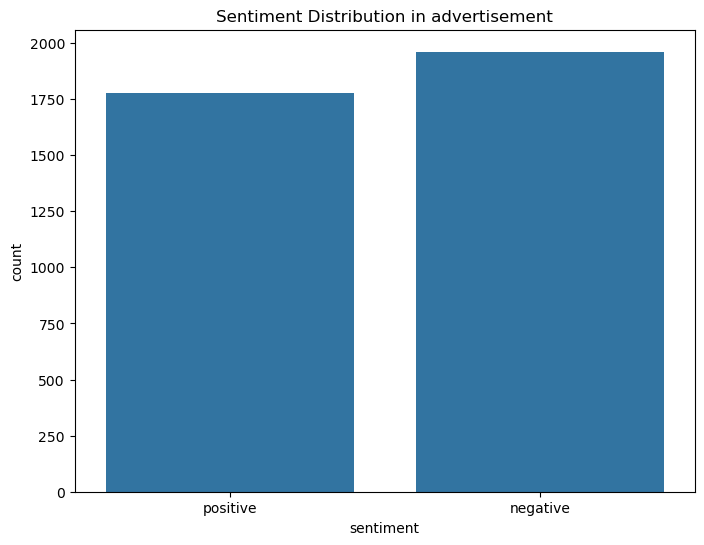

Processing print's data:
The number of data in drawing is 9246
After deleting repeated data, the number of data in print is 1587


,comment_id,create_time,content,nickname,sub_comment_count,like_count,sentiment
0,668ff4700000000005033a72,1720710257000,审了六个小时把之前的文案补上：al大概是想通过反抗告诉我现在大海受到污染已经没办法生成正常童...,陶小雨_深圳约拍女摄,12,3967,positive
1,6690be0000000000050215ce,1720761856000,看着生理不适感觉滑不溜秋还有腥味不愧是ai,好好说话会死嘛,21,7272,positive
2,668ffacc0000000016027eb9,1720711885000,除了不像鱼尾巴以外感觉这个挺好看,cn,80,5001,positive
3,66906d73000000000503abf5,1720741236000,其他不成功的好像被核废水污染了的美人鱼,当米煮成稀饭,7,3814,negative
4,66905d9c0000000005030982,1720737181000,我觉得这条还挺好看的呀,奥特.曼佳,18,1258,positive


<class 'pandas.core.frame.DataFrame'>
Index: 1587 entries, 0 to 8898
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         1587 non-null   object
 1   create_time        1587 non-null   int64 
 2   content            1587 non-null   object
 3   nickname           1587 non-null   object
 4   sub_comment_count  1587 non-null   int64 
 5   like_count         1587 non-null   object
 6   sentiment          1587 non-null   object
dtypes: int64(2), object(5)
memory usage: 99.2+ KB


None

,create_time,sub_comment_count
count,1.587000e+03,1587.000000
mean,1.719936e+12,0.521109
std,2.658913e+09,6.983680
min,1.716227e+12,0.000000
25%,1.717157e+12,0.000000
50%,1.720766e+12,0.000000
75%,1.722175e+12,0.000000
max,1.727841e+12,251.000000


sentiment
positive    880
negative    707
Name: count, dtype: int64


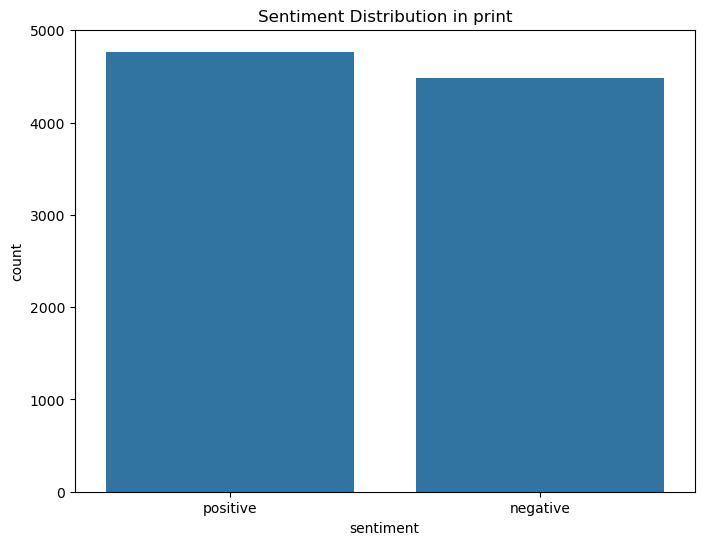

Processing technology's data:
The number of data in technological development is 1343
The number of data in Technology Outlook is 5237
After deleting repeated data, the number of data in technology is 5696


,comment_id,create_time,content,nickname,sub_comment_count,like_count,sentiment
0,658e7ddd000000001a00e241,1703837149000,六根手指都不够明显吗？,momo,303,2.8万,positive
1,658ef186000000001702da48,1703866758000,这种胖度这样坐着是不会有锁骨的,冒冒了个彪😱（装修版）,1059,1.5万,positive
2,658f627c000000001b01d7d5,1703895676000,手指头数量要是对就更好了,弥鹿,38,1860,negative
3,662dc6810000000013027e0b,1714275970000,这种画面油腻感和ai不会画手就开始随处藏的毛病我看是改不了了,小狗麵包🍞,0,116,negative
4,66725fda000000002100d25c,1718771674000,看起来像一个丰盈的甜美的女子身材好漂亮带的出去看起来甜美攻击性弱旺夫我是男的我也喜欢但我是女...,快乐大列巴「搞钱版」,6,30,positive


<class 'pandas.core.frame.DataFrame'>
Index: 5696 entries, 0 to 5236
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   comment_id         5696 non-null   object
 1   create_time        5696 non-null   int64 
 2   content            5696 non-null   object
 3   nickname           5696 non-null   object
 4   sub_comment_count  5696 non-null   int64 
 5   like_count         5696 non-null   object
 6   sentiment          5696 non-null   object
dtypes: int64(2), object(5)
memory usage: 356.0+ KB


None

,create_time,sub_comment_count
count,5.696000e+03,5696.000000
mean,1.718278e+12,0.546699
std,9.031010e+09,14.845092
min,1.675248e+12,0.000000
25%,1.716679e+12,0.000000
50%,1.717759e+12,0.000000
75%,1.726092e+12,0.000000
max,1.728632e+12,1059.000000


sentiment
positive    3098
negative    2598
Name: count, dtype: int64


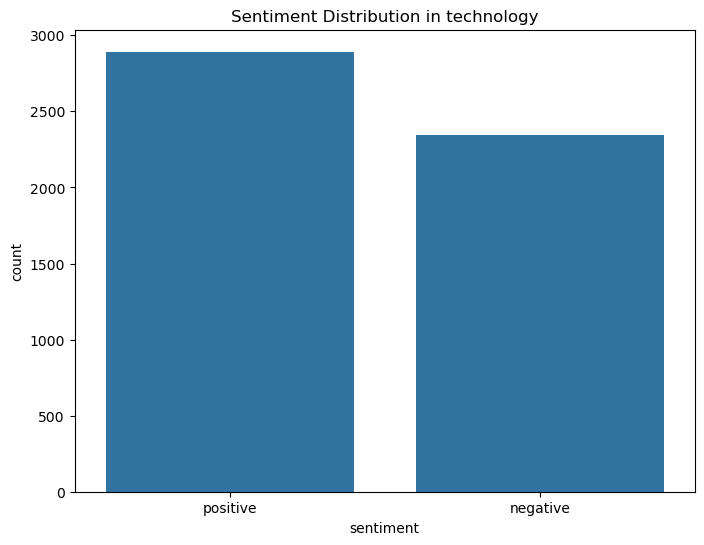

In [17]:
# Pre-processing every field's data
for field in fields:
    field_name = field['name']
    print(f'Processing {field_name}\'s data:')
    
    dfs = []
    for file in field['files']:
        try:
            # Find the encoding of the file
            with open(f'data/ai-{field_name}/Comments-{file}.csv', 'rb') as f:
                result = chardet.detect(f.read())
            # Read the data
            df = pd.read_csv(f'data/ai-{field_name}/Comments-{file}.csv', encoding=result['encoding'], encoding_errors='replace')
             # Check the data
            print(f'The number of data in {file} is {len(df)}')
            # Delete the unneeded columns
            df = df.drop(columns=['ip_location', 'note_id', 'user_id', 'avatar', 'pictures', 'parent_comment_id', 'last_modify_ts'])
            dfs.append(df)
        except Exception as e:
            print(f'Fail to load {file} file: {e}')

    # Merging all data in every field
    df_field = pd.concat(dfs)
    # Delete the data with the same comment_id
    df_field = df_field.drop_duplicates(subset=['comment_id'])
    print(f'After deleting repeated data, the number of data in {field_name} is {len(df_field)}')
    # Fill in the missing nickname
    df_field = df_field.fillna('匿名用户')
    display(df_field.head())
    display(df_field.info())
    display(df_field.describe())

    # Store the field's all data
    df_field['processed_content'] = df_field['content'].apply(preprocess_text_zh)
    fields_data[field_name] = df_field

    # Check the distribution of the sentiment
    sentiment_distribution = df_field['sentiment'].value_counts()
    print(sentiment_distribution)
    plt.figure(figsize=(8,6))
    sns.countplot(x='sentiment', data=df)
    plt.title(f'Sentiment Distribution in {field_name}')
    plt.show()

Analyzing advertisement field:
Use NB model in advertisement field:
NB model in advertisement's accuracy: 0.8614800759013282, f1 score: 0.8614314074403345
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.88      0.87      1071
    positive       0.87      0.85      0.86      1037

    accuracy                           0.86      2108
   macro avg       0.86      0.86      0.86      2108
weighted avg       0.86      0.86      0.86      2108



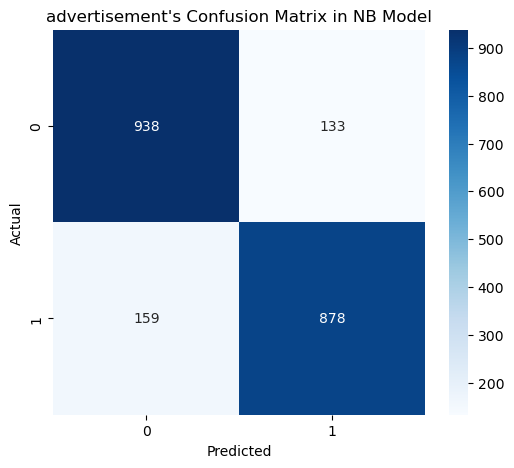

Use SVM model in advertisement field:
SVM model in advertisement's accuracy: 0.8799810246679317, f1 score: 0.8796727130554092
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.92      0.89      1071
    positive       0.91      0.83      0.87      1037

    accuracy                           0.88      2108
   macro avg       0.88      0.88      0.88      2108
weighted avg       0.88      0.88      0.88      2108



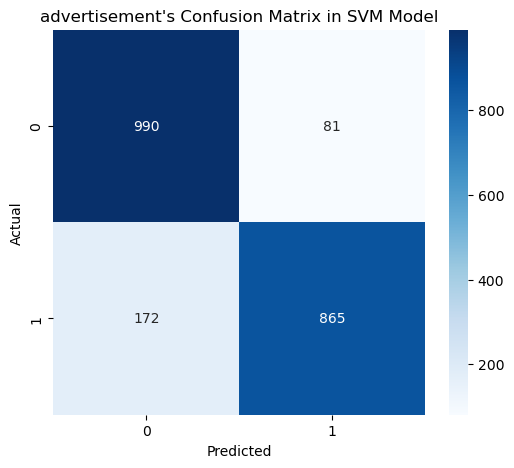

Analyzing print field:
Use NB model in print field:
NB model in print's accuracy: 0.720125786163522, f1 score: 0.7067693225524172
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.51      0.63       150
    positive       0.67      0.91      0.77       168

    accuracy                           0.72       318
   macro avg       0.75      0.71      0.70       318
weighted avg       0.75      0.72      0.71       318



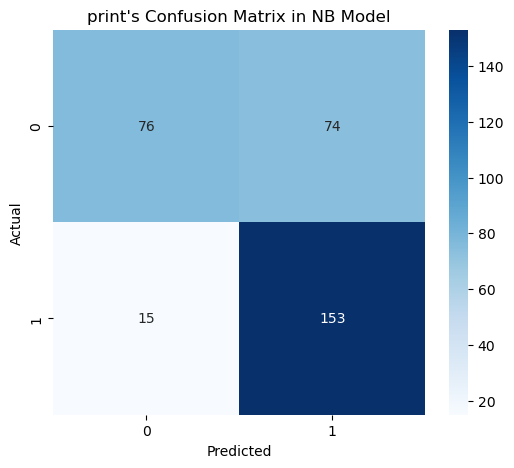

Use SVM model in print field:
SVM model in print's accuracy: 0.7735849056603774, f1 score: 0.773262377035962
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.84      0.78       150
    positive       0.83      0.71      0.77       168

    accuracy                           0.77       318
   macro avg       0.78      0.78      0.77       318
weighted avg       0.78      0.77      0.77       318



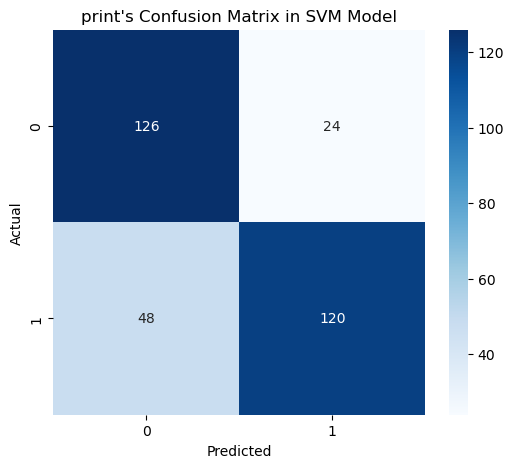

Analyzing technology field:
Use NB model in technology field:
NB model in technology's accuracy: 0.7684210526315789, f1 score: 0.7602062588904694
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.59      0.70       531
    positive       0.72      0.93      0.81       609

    accuracy                           0.77      1140
   macro avg       0.80      0.76      0.76      1140
weighted avg       0.79      0.77      0.76      1140



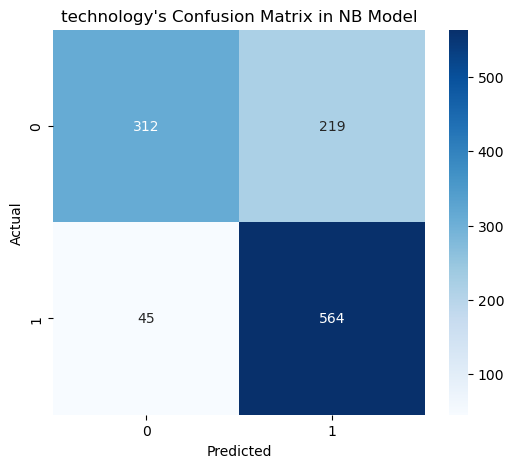

Use SVM model in technology field:
SVM model in technology's accuracy: 0.8035087719298246, f1 score: 0.8035318559556788
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       531
    positive       0.82      0.81      0.82       609

    accuracy                           0.80      1140
   macro avg       0.80      0.80      0.80      1140
weighted avg       0.80      0.80      0.80      1140



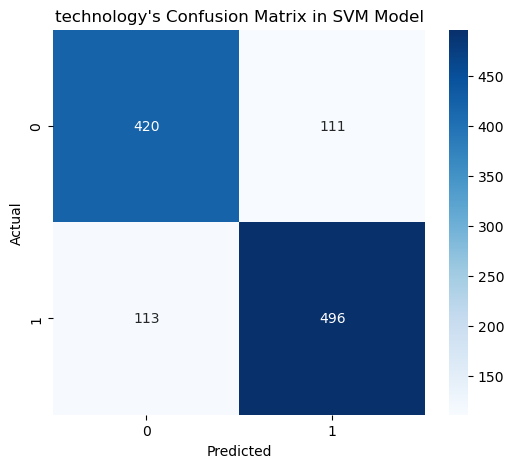

In [18]:
# Process the feature engineering, model training and evaluating in every field
for field_name, df in fields_data.items():
    print(f'Analyzing {field_name} field:')
    vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenizer, token_pattern=None, max_features=5000)
    X = vectorizer.fit_transform(df['processed_content'])
    # Split the training set and the test set
    X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=1)
    # Store the results of the field
    fields_results[field_name] = {}
    # Train every model
    for model_name, model in models.items():
        print(f'Use {model_name} model in {field_name} field:')
        model.fit(X_train, y_train)
        # Test the model
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions, output_dict=True)
        conf_matrix = confusion_matrix(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='weighted')
        # Store the results
        fields_results[field_name][model_name] = {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'f1_score': f1
        }
        print(f'{model_name} model in {field_name}\'s accuracy: {accuracy}, f1 score: {f1}')
        print(f'Classification Report:\n{classification_report(y_test, predictions)}')
        plt.figure(figsize=(6,5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{field_name}\'s Confusion Matrix in {model_name} Model')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

<Figure size 1000x600 with 0 Axes>

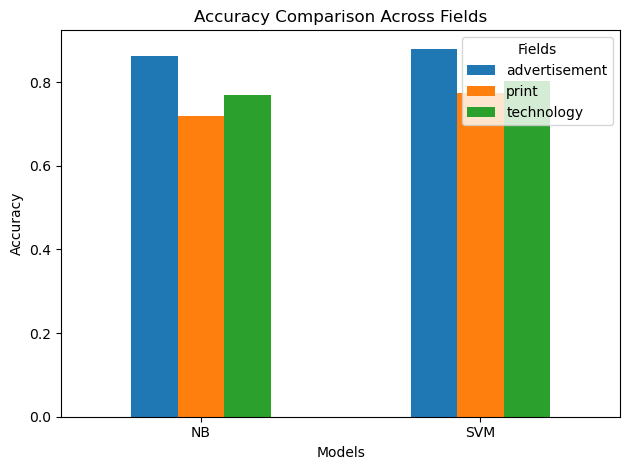

<Figure size 1000x600 with 0 Axes>

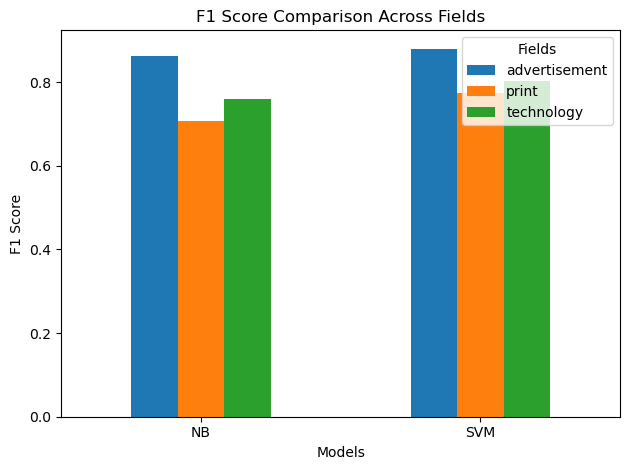

<Figure size 1000x600 with 0 Axes>

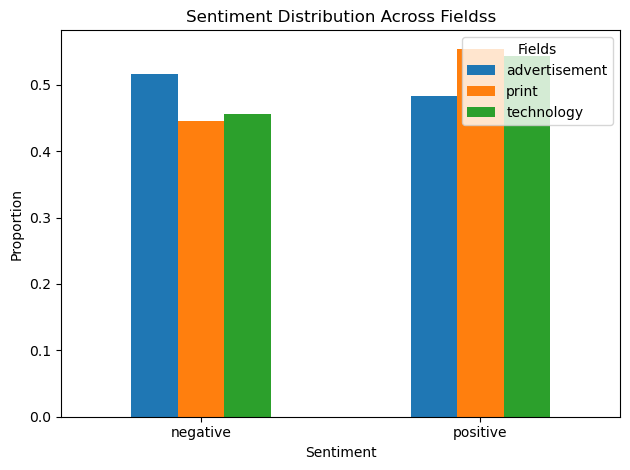

In [19]:
# Compare different fields' data
fields_list = list(fields_results.keys())
model_names = list(models.keys())
acc_data = {field: [fields_results[field][model]['accuracy'] for model in model_names] for field in fields_list}
acc_df = pd.DataFrame(acc_data, index=model_names)
f1_data = {field: [fields_results[field][model]['f1_score'] for model in model_names] for field in fields_list}
f1_df = pd.DataFrame(f1_data, index=model_names)

# Plot the comparison images
plt.figure(figsize=(10, 6))
acc_df.plot(kind='bar', rot=0)
plt.title('Accuracy Comparison Across Fields')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.legend(title='Fields')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
f1_df.plot(kind='bar', rot=0)
plt.title('F1 Score Comparison Across Fields')
plt.ylabel('F1 Score')
plt.xlabel('Models')
plt.legend(title='Fields')
plt.tight_layout()
plt.show()

sentiment_distribution = {field: fields_data[field]['sentiment'].value_counts(normalize=True) 
                         for field in fields_data.keys()}
sentiment_df = pd.DataFrame(sentiment_distribution)

plt.figure(figsize=(10, 6))
sentiment_df.plot(kind='bar', rot=0)
plt.title('Sentiment Distribution Across Fieldss')
plt.ylabel('Proportion')
plt.xlabel('Sentiment')
plt.legend(title='Fields')
plt.tight_layout()
plt.show()